<a href="https://colab.research.google.com/github/jwyangyin/TFM/blob/main/TFM_Notebook_2_(Master_Data_Science)_Sistema_de_recomendaci%C3%B3n_basado_en_contenido_(Content_Based_Filtering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>1. Introducción</h1>

<p>
En este cuaderno implementamos el <b>Sistema 2</b>: un <b>sistema de recomendación basado en contenido</b> para la categoría
<b>All_Beauty</b> del dataset <b>Amazon Reviews’23</b>. A diferencia del Sistema 1 (colaborativo Item-to-Item), aquí generamos recomendaciones
comparando <b>características del propio producto</b> (texto y metadatos), lo que permite mitigar parcialmente el problema de
<i>cold-start</i> cuando no existe suficiente historial de interacciones.
</p>

<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
  <b>Objetivo práctico:</b> dado un producto (por <code>parent_asin</code>), recomendar otros productos <b>similares por contenido</b>
  (título, descripción, características, marca/categoría) mediante representaciones vectoriales y similitud coseno.
</div>

<p style="margin-top:10px;">
Para evitar duplicar contenido, la descripción detallada del dataset, su origen, y el diagnóstico de esparsidad/long-tail se encuentra en el
<b>Notebook del Sistema 1 (Item-to-Item)</b>. En este cuaderno reutilizamos las mismas fuentes y nos centramos en el modelado basado en contenido.
</p>

<br>
<h2>1.1. Fuentes de datos y estructura</h2>

<p>
Usamos los mismos ficheros del Sistema 1 (Amazon Reviews’23 – All_Beauty) descargados de:
<a href="https://amazon-reviews-2023.github.io/" target="_blank">https://amazon-reviews-2023.github.io/</a>.
</p>

<ul>
  <li><b>User Reviews</b> (<code>All_Beauty.jsonl</code>): interacciones usuario–producto (se usa de apoyo para análisis, no es el núcleo del modelo).</li>
  <li><b>Item Metadata</b> (<code>meta_All_Beauty.jsonl</code>): metadatos del producto (es el núcleo del enfoque basado en contenido).</li>
</ul>

<p>
La unidad de recomendación se mantiene a nivel de <b><code>parent_asin</code></b> (coherente con el Sistema 1) para agrupar variantes (<code>asin</code>)
y asegurar consistencia en el catálogo.
</p>


<br>
<h2>1.2. Carga de datos</h2>

<p>
Cargamos los ficheros del subconjunto <b>All_Beauty</b> en formato <b>JSONL</b> (un JSON por línea):
(i) reseñas de usuarios (<code>df_reviews</code>) y
(ii) metadatos de productos (<code>df_meta</code>).
Dado el tamaño de ambos ficheros, la lectura se realiza de forma <b>secuencial</b> para reducir el consumo de memoria y garantizar estabilidad en el entorno de ejecución.
</p>

<p>
Tras la carga, se realizan comprobaciones básicas de integridad: número de filas, columnas disponibles y presencia de la clave
<code>parent_asin</code>, que actúa como identificador de producto y permite enlazar reseñas y metadatos de forma consistente.
</p>

<p>
A diferencia del <b>Sistema 1 (Item-to-Item)</b>, donde la carga de datos se orientaba a la construcción de la matriz usuario–ítem,
en este <b>Sistema 2 (basado en contenido)</b> el foco está en preparar el catálogo de productos para su posterior análisis
mediante atributos y texto. El proceso de limpieza, selección de campos y análisis exploratorio específico de contenido
se desarrolla en los apartados siguientes.
</p>


In [1]:
# Montamos Google Drive en Colab:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Importamos las librerías necesarias:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Rutas (ajusta si tu estructura es distinta):
path_reviews = "/content/drive/My Drive/Colab Notebooks/All_Beauty.jsonl"
path_meta    = "/content/drive/My Drive/Colab Notebooks/meta_All_Beauty.jsonl"

def read_jsonl(path: str, max_rows: int = None) -> pd.DataFrame:
    """
    Lee un JSONL (un JSON por línea) de forma secuencial para reducir memoria.
    - max_rows: si quieres cargar solo una parte (debug). None = todo.
    """
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_rows is not None and i >= max_rows:
                break
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

In [3]:
# Mostramos las primeras 5 líneas del dataset df_reviews:
df_reviews = read_jsonl(path_reviews)
df_reviews.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [4]:
# Mostramos las primeras 5 líneas del dataset df_meta:
df_meta = read_jsonl(path_meta)
df_meta.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Howard Products,[],{'Package Dimensions': '7.1 x 5.5 x 3 inches; ...,B01CUPMQZE,None
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Yes To,[],"{'Item Form': 'Powder', 'Skin Type': 'Acne Pro...",B076WQZGPM,None
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Levine Health Products,[],{'Manufacturer': 'Levine Health Products'},B000B658RI,None
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",3.1,102,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Cherioll,[],"{'Brand': 'Cherioll', 'Item Form': 'Powder', '...",B088FKY3VD,None
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7,"[Material: 304 Stainless Steel; Brass tip, Len...",[The Precision Plunger Bars are designed to wo...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Precision,[],{'UPC': '644287689178'},B07NGFDN6G,None


In [5]:
# --- Realizamos chequeos básicos ---
print("Dimensiones cargadas:")
print("df_reviews shape:", df_reviews.shape)
print("df_meta    shape:", df_meta.shape)

print("\nColumnas df_reviews:", list(df_reviews.columns))
print("\nColumnas df_meta:", list(df_meta.columns))

Dimensiones cargadas:
df_reviews shape: (701528, 10)
df_meta    shape: (112590, 14)

Columnas df_reviews: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

Columnas df_meta: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']


In [6]:
# Clave mínima para enlazar parent_asin:
assert "parent_asin" in df_reviews.columns, "Falta 'parent_asin' en df_reviews."
assert "parent_asin" in df_meta.columns, "Falta 'parent_asin' en df_meta."

print("\nOK: 'parent_asin' presente en ambos datasets.")


OK: 'parent_asin' presente en ambos datasets.


<br>
<h2>1.3. Contexto de los datos</h2>

<p>
Este segundo sistema utiliza el mismo dominio y fuentes que el <b>Sistema 1 (Item-to-Item)</b> (Amazon Reviews’23,
subconjunto <b>All Beauty</b>): un fichero de <i>reviews</i> (interacciones) y un fichero de <i>metadatos</i> (catálogo).
La diferencia clave es el objetivo: aquí modelamos similitud entre productos a partir de sus <b>atributos</b> y/o <b>texto</b>,
por lo que el dataset central es <code>df_meta</code> y las <code>reviews</code> se usan como soporte para validaciones y escenarios de uso.
</p>

<ul>
  <li><b>df_reviews (interacciones):</b> reseñas con <code>user_id</code>, <code>parent_asin</code>, <code>rating</code> y <code>timestamp</code>.
      En este sistema se emplea principalmente para: (i) definir histórico/semillas de usuario en demos, y (ii) evaluación/validación si se aplica un protocolo offline.</li>
  <li><b>df_meta (catálogo):</b> información del producto indexada por <code>parent_asin</code>.
      Es la base del recomendador de contenido, ya que aporta los campos informativos para construir la representación de cada ítem
      (p. ej., <code>title</code>, <code>description</code>, <code>features</code>, <code>brand</code>, <code>categories</code>, según disponibilidad real).</li>
</ul>

<p>
Es decir:
</p>

<h3>A) Variables de interacción (User Reviews) — 10 campos</h3>

In [7]:
# Variables del dataset de reseñas:
print("Variables (User Reviews):",list(df_reviews.columns))
print("Número de variables (User Reviews):", df_reviews.shape[1])

Variables (User Reviews): ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']
Número de variables (User Reviews): 10


<table style="width:100%; border-collapse:collapse;">
  <thead>
    <tr style="background:#f2f2f2;">
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Campo</th>
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Tipo</th>
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>rating</code></td><td style="padding:8px; border:1px solid #ddd;">float</td><td style="padding:8px; border:1px solid #ddd;">Valoración del producto (de 1.0 a 5.0).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>title</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Título de la reseña escrita por el usuario.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>text</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Cuerpo (texto completo) de la reseña del usuario.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>images</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Lista de imágenes aportadas por el usuario (URLs en distintos tamaños).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>asin</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Identificador del producto (a nivel de variante/SKU).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>parent_asin</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Identificador “padre” que agrupa variantes (color, talla, estilo).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>user_id</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Identificador anónimo del usuario que escribe la reseña.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>timestamp</code></td><td style="padding:8px; border:1px solid #ddd;">int</td><td style="padding:8px; border:1px solid #ddd;">Momento de la reseña (tiempo Unix).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>verified_purchase</code></td><td style="padding:8px; border:1px solid #ddd;">bool</td><td style="padding:8px; border:1px solid #ddd;">Indicador de compra verificada del usuario.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>helpful_vote</code></td><td style="padding:8px; border:1px solid #ddd;">int</td><td style="padding:8px; border:1px solid #ddd;">Número de votos de utilidad (“helpful votes”) de la reseña.</td></tr>
  </tbody>
</table>

<h3>B) Variables de producto (Item Metadata) — 14 campos</h3>

In [8]:
# Variables del dataset de metadatos:
print("Variables (Item Metadata):",list(df_meta.columns))
print("Número de variables (Item Metadata):", df_meta.shape[1])

Variables (Item Metadata): ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']
Número de variables (Item Metadata): 14


<table style="width:100%; border-collapse:collapse;">
  <thead>
    <tr style="background:#f2f2f2;">
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Campo</th>
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Tipo</th>
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>main_category</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Categoría principal (dominio) del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>title</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Nombre del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>average_rating</code></td><td style="padding:8px; border:1px solid #ddd;">float</td><td style="padding:8px; border:1px solid #ddd;">Valoración media mostrada en la página del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>rating_number</code></td><td style="padding:8px; border:1px solid #ddd;">int</td><td style="padding:8px; border:1px solid #ddd;">Número total de valoraciones del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>features</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Características en formato viñetas (“bullet points”).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>description</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Descripción del producto (habitualmente en lista).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>price</code></td><td style="padding:8px; border:1px solid #ddd;">float</td><td style="padding:8px; border:1px solid #ddd;">Precio en dólares estadounidenses (en el momento del crawling).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>images</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Imágenes del producto (thumb/large/hi_res) y su “variant”.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>videos</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Vídeos del producto (título y URL).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>store</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Nombre de la tienda/vendedor del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>categories</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Categorías jerárquicas del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>details</code></td><td style="padding:8px; border:1px solid #ddd;">dict</td><td style="padding:8px; border:1px solid #ddd;">Detalles del producto (marca, material, tamaños, etc.).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>parent_asin</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Identificador “padre” del producto (clave para unir con reseñas).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>bought_together</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Bundles recomendados (“frecuentemente comprados juntos”).</td></tr>
  </tbody>
</table>

<br>
<h2>1.4. Estadísticas básicas del subconjunto All_Beauty</h2>

<p>
Como primer diagnóstico, resumimos el tamaño del problema en el subconjunto <b>All_Beauty</b> usando:
(i) <code>df_reviews</code> (interacciones) y (ii) <code>df_meta</code> (catálogo). En este Sistema 2 (contenido),
estas magnitudes nos sirven para dimensionar el catálogo a representar (por <code>parent_asin</code>) y anticipar
retos de cobertura textual.
</p>

<ul>
  <li><b>Reseñas (interacciones)</b>: 701.528</li>
  <li><b>Usuarios únicos</b>: 631.986</li>
  <li><b>Ítems únicos</b> (por <code>parent_asin</code>, desde <code>df_reviews</code>): 112.565</li>
  <li><b>Filas de catálogo</b> (productos en <code>df_meta</code>): 112.590</li>
  <li><b><code>parent_asin</code> únicos</b> en <code>df_meta</code>: 112.590</li>
</ul>

</p>

In [9]:
# Estadísticas básicas desde df_reviews:
n_reviews = df_reviews.shape[0]                      # nº de interacciones (filas)
n_users = df_reviews["user_id"].nunique()            # usuarios únicos
n_items_parent = df_reviews["parent_asin"].nunique() # ítems únicos (por parent_asin)

print("Estadísticas básicas (All_Beauty - User Reviews):")
print(f"- Reseñas (interacciones): {n_reviews:,}".replace(",", "."))
print(f"- Usuarios únicos: {n_users:,}".replace(",", "."))
print(f"- Ítems únicos (por parent_asin): {n_items_parent:,}".replace(",", "."))

Estadísticas básicas (All_Beauty - User Reviews):
- Reseñas (interacciones): 701.528
- Usuarios únicos: 631.986
- Ítems únicos (por parent_asin): 112.565


In [10]:
# Mostramos las estadísticas básicas desde df_meta:
n_rows_meta = df_meta.shape[0]
n_items_meta = df_meta["parent_asin"].nunique()

print("\nEstadísticas básicas (All_Beauty - Item Metadata):")
print(f"- Filas (productos): {n_rows_meta:,}".replace(",", "."))
print(f"- parent_asin únicos: {n_items_meta:,}".replace(",", "."))


Estadísticas básicas (All_Beauty - Item Metadata):
- Filas (productos): 112.590
- parent_asin únicos: 112.590


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<b>Implicación práctica:</b> el volumen de usuarios e interacciones es grande, pero el dominio es altamente disperso (long-tail),
por lo que muchas entidades tienen poca evidencia en comportamiento. A diferencia del Sistema 1 (colaborativo),
aquí el foco no es construir co-ocurrencias usuario–ítem, sino asegurar que el catálogo (<code>df_meta</code>) dispone de
atributos/texto suficientes para construir una representación por producto. Por ello, en el EDA específico de contenido
analizaremos la <b>cobertura y calidad del texto</b> (campos disponibles, nulos, longitudes y proporción de productos con
información útil).
</div>

<hr>
<br>
<h1>2. Enfoque del modelo: Recomendación basada en contenido</h1>

<p>
En este segundo sistema aplicamos un <b>enfoque de recomendación basada en contenido (Content-Based Filtering)</b>.
A diferencia del Sistema 1 (filtrado colaborativo Item-to-Item), donde las recomendaciones se derivan de
<b>patrones de co-ocurrencia entre usuarios y productos</b>, aquí el objetivo es <b>modelar la similitud entre productos
a partir de sus propias características</b>.
</p>


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
La idea central es sencilla: <b>dos productos son similares si comparten atributos descriptivos parecidos</b>,
como el título, la descripción, las características del producto, la marca o la categoría. De este modo, podemos
recomendar productos <b>incluso cuando no existen interacciones previas suficientes</b>, mitigando parcialmente el
problema de <i>cold-start</i>.
</div>


<br/>

<h2>2.1. Intuición del enfoque</h2>

<p>
Si observamos dos productos que presentan descripciones textuales similares —por ejemplo, comparten ingredientes,
tipo de uso o categoría cosmética—, interpretamos que dichos productos están relacionados desde el punto de vista del contenido.
</p>

<p>
Por tanto, cuando un usuario interactúa con un producto concreto (o cuando queremos encontrar productos alternativos a uno dado),
podemos recomendar <b>otros productos con contenido similar</b>, sin necesidad de apoyarnos en el comportamiento de otros usuarios.
</p>>


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;"><b>Regla práctica:</b>
“Dado un producto A, recomendamos productos cuyo contenido sea más similar al de A”.
</div>

<p>Este enfoque resulta especialmente adecuado en escenarios donde:</p>
<ul>
  <li>hay <b>muchos productos con pocas interacciones</b>,</li>
  <li>los usuarios tienen historiales cortos o inexistentes,</li>
  <li>o se desea ofrecer recomendaciones explicables basadas en atributos del producto.</li>
</ul>

<br>

<h2>2.2. Representación de los datos</h2>

<p>
En el sistema basado en contenido, el objeto central de modelado es el <b>ítem</b>, no el usuario. Cada producto se
representa mediante un conjunto de <b>atributos descriptivos</b>, principalmente de tipo textual.
</p>

<p>
A nivel conceptual, transformamos cada producto en un <b>“documento”</b>, construido a partir de los campos disponibles
en <code>df_meta</code>, tales como:
</p>

<ul>
  <li><code>title</code></li>
  <li><code>description</code></li>
  <li><code>features</code></li>
  <li><code>brand</code></li>
  <li><code>categories</code></li>
  <li>(según disponibilidad real en el dataset)</li>
</ul>

<p>
Estos campos se combinan y procesan para obtener una <b>representación vectorial</b> de cada producto, que permita comparar
ítems entre sí de forma cuantitativa.
</p>

<p>
Las interacciones (<code>df_reviews</code>) no se utilizan para construir el modelo de similitud, sino como <b>soporte para demos,
validaciones y escenarios de evaluación</b>.
</p>

<br>

<h2>2.3. Cálculo de similitud entre ítems</h2>

<p>
Una vez obtenida la representación vectorial de cada producto, calculamos una <b>matriz de similitud ítem-ítem basada en contenido</b>.
</p>

<p>
La similitud mide hasta qué punto dos productos son parecidos <b>en términos de sus atributos</b>, no de su consumo conjunto por usuarios.
Una opción habitual y ampliamente utilizada es la <b>similitud del coseno</b>, que compara el ángulo entre los vectores de contenido de dos productos.
</p>

<p>
Intuitivamente:
</p>
<ul>
  <li>productos con descripciones muy parecidas tendrán similitud alta,</li>
  <li>productos con contenido distinto tendrán similitud baja.</li>
</ul>

<p>
Este cálculo se realiza sobre matrices potencialmente grandes, por lo que se emplean <b>representaciones eficientes</b>
(por ejemplo, matrices dispersas) para mantener un coste computacional razonable.
</p>

<br>

<h2>2.4. Generación de recomendaciones</h2>

<p>La generación de recomendaciones sigue un esquema directo:</p>
<ol>
  <li>Seleccionamos un <b>producto de referencia</b> (por ejemplo, un <code>parent_asin</code>).</li>
  <li>Recuperamos los <b>productos más similares por contenido</b> según la matriz de similitud.</li>
  <li>Devolvemos los <b>Top-N productos</b> con mayor similitud, excluyendo el propio ítem de partida.</li>
</ol>

<p>
El resultado es una lista de productos recomendados basada exclusivamente en <b>similitud semántica y estructural del contenido</b>,
independiente del comportamiento agregado de los usuarios.
</p>

<p>Este mecanismo permite:</p>
<ul>
  <li>recomendar productos nuevos sin historial,</li>
  <li>ofrecer alternativas similares a un producto concreto,</li>
  <li>y proporcionar recomendaciones fácilmente explicables (“se recomienda porque es similar en contenido”).</li>
</ul>

<br>

<h2>2.5. Justificación del enfoque basado en contenido</h2>

<p>
Este enfoque encaja bien con el dataset considerado debido a la <b>alta esparsidad observada en las interacciones</b>,
donde muchos productos y usuarios presentan muy poca evidencia de comportamiento.
</p>

<p>
El recomendador basado en contenido:
</p>
<ul>
  <li>no depende de co-ocurrencias entre usuarios,</li>
  <li>puede operar con <b>una única entidad observada</b> (un producto),</li>
  <li>y permite mitigar el <i>cold-start</i> de ítems al apoyarse en información descriptiva.</li>
</ul>

<p>
Además, es especialmente útil como complemento a enfoques colaborativos, aportando robustez en escenarios donde
el filtrado colaborativo pierde eficacia.
</p>

<br>

<h2>2.6. Limitaciones del enfoque</h2>

<p>
A pesar de sus ventajas, este enfoque presenta algunas limitaciones relevantes:
</p>

<ul>
  <li><b>Dependencia de la calidad del contenido:</b> si los textos son escasos, ruidosos o inconsistentes, la similitud estimada puede ser poco fiable.</li>
  <li><b>Falta de personalización profunda:</b> al no modelar directamente preferencias de usuario, las recomendaciones tienden a ser más genéricas.</li>
  <li><b>Sobre-especialización:</b> el sistema puede recomendar productos muy similares entre sí, reduciendo diversidad si no se controla explícitamente.</li>
</ul>

<p>
En la práctica, estas limitaciones justifican el uso de <b>enfoques híbridos</b>, que combinen información de contenido y comportamiento,
aspecto que se discute en capítulos posteriores del trabajo.
</p>

<hr>
<br>
<h1>3. Análisis exploratorio (EDA) y diagnóstico del dataset</h2>

<p>
Antes de construir el sistema de recomendación basado en contenido (Sistema 2),
es necesario analizar la calidad y coherencia del dataset desde una perspectiva
exploratoria. A diferencia del Sistema 1, centrado en interacciones usuario–ítem,
el rendimiento del sistema basado en contenido depende directamente de la calidad
de los metadatos textuales asociados a cada producto.
</p>

<p>
El objetivo de este capítulo es evaluar si el dataset proporciona información
suficiente, consistente y semánticamente útil para construir representaciones
textuales comparables entre productos.
</p>

<p>
El análisis se estructura en tres bloques principales:
</p>

<ul>
  <li>Calidad de los metadatos y coherencia entre ficheros.</li>
  <li>Cobertura real del contenido textual por campo.</li>
  <li>Diagnóstico semántico del texto y definición del documento de ítem.</li>
</ul>
<br>
<h2>3.1 Calidad de los metadatos y coherencia entre ficheros</h3>

<p>
El primer paso del análisis exploratorio consiste en evaluar la calidad estructural
del dataset de metadatos (<code>df_meta</code>), que actúa como catálogo central del
sistema de recomendación basado en contenido.
</p>

<p>
En este apartado se analizan tres aspectos clave:
</p>

<ul>
  <li>Presencia de valores nulos y tipos inconsistentes en campos informativos.</li>
  <li>Unicidad del identificador <code>parent_asin</code>.</li>
  <li>Coherencia entre los productos presentes en los ficheros de interacciones
      y el catálogo de metadatos.</li>
</ul>

<p>
Este análisis permite asegurar que los productos con interacciones disponen de
información asociada y que el catálogo es consistente antes de construir
representaciones basadas en contenido.
</p>

In [11]:
# -------------------------
# 1) Información general del dataset de metadatos:
# -------------------------
# Tamaño del dataset:
df_meta.shape

# Tipo de variable del dataset:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112590 entries, 0 to 112589
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   main_category    112590 non-null  object 
 1   title            112590 non-null  object 
 2   average_rating   112590 non-null  float64
 3   rating_number    112590 non-null  int64  
 4   features         112590 non-null  object 
 5   description      112590 non-null  object 
 6   price            17704 non-null   float64
 7   images           112590 non-null  object 
 8   videos           112590 non-null  object 
 9   store            101259 non-null  object 
 10  categories       112590 non-null  object 
 11  details          112590 non-null  object 
 12  parent_asin      112590 non-null  object 
 13  bought_together  0 non-null       object 
dtypes: float64(2), int64(1), object(11)
memory usage: 12.0+ MB


In [12]:
# Porcentaje de valores nulos por columna:
(df_meta.isna().mean() * 100).sort_values(ascending=False)

,0
bought_together,100.000000
price,84.275691
store,10.063949
average_rating,0.000000
main_category,0.000000
title,0.000000
description,0.000000
features,0.000000
rating_number,0.000000
images,0.000000


In [13]:
# -------------------------
# 2) Análisis de duplicados por parent_asin:
# -------------------------
n_total = len(df_meta)
n_unique = df_meta["parent_asin"].nunique()
n_duplicates = n_total - n_unique

print(f"Nº total de filas: {n_total}")
print(f"Nº parent_asin únicos: {n_unique}")
print(f"Nº duplicados potenciales: {n_duplicates}")

# Ejemplos de duplicados (si existen):
df_meta[df_meta.duplicated("parent_asin", keep=False)].head()

Nº total de filas: 112590
Nº parent_asin únicos: 112590
Nº duplicados potenciales: 0


,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together


In [14]:
# -------------------------
# 3) Coherencia entre interacciones y metadatos:
# -------------------------
# parent_asin presentes en reviews:
asins_reviews = set(df_reviews["parent_asin"].astype(str))

# parent_asin presentes en meta:
asins_meta = set(df_meta["parent_asin"].astype(str))

coverage_reviews_to_meta = len(asins_reviews & asins_meta) / len(asins_reviews)

print(f"Cobertura reviews → meta: {coverage_reviews_to_meta:.4f}")

Cobertura reviews → meta: 1.0000


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;"><b>Conclusión:</b> El análisis de la calidad de los metadatos y de la coherencia entre ficheros confirma que el dataset presenta una <b>estructura sólida y consistente</b> para la construcción de un sistema de recomendación basado en contenido. El catálogo de metadatos (<code>df_meta</code>) contiene <b>112.590 productos únicos</b>, sin duplicados en el identificador <code>parent_asin</code>, lo que garantiza una correspondencia uno a uno entre producto y representación textual.<br><br>
En cuanto a la calidad de los campos, los atributos clave para el modelado basado en contenido (<code>title</code>, <code>description</code>, <code>features</code> y <code>main_category</code>) presentan <b>ausencia total de valores nulos</b>, mientras que los campos con alta tasa de valores faltantes (como <code>price</code> o <code>bought_together</code>) no son críticos para este sistema y pueden excluirse sin impacto en la representación semántica.<br><br>
Finalmente, la cobertura entre los ficheros de interacciones y el catálogo de metadatos es <b>completa (100%)</b>, lo que asegura que todos los productos con interacciones disponen de información asociada. En conjunto, estos resultados validan que el dataset cumple las condiciones mínimas necesarias para avanzar hacia el análisis de cobertura de contenido y el diagnóstico semántico del texto en los siguientes apartados.

</div>

<h2>3.2. Cobertura de contenido por campo (texto y atributos)</h3>

<p>
En un sistema de recomendación <b>basado en contenido</b>, la calidad de las recomendaciones depende de la
<b>cantidad real de información disponible</b> por producto. Por ello, antes de construir el “documento de ítem”,
medimos la <b>cobertura</b> (porcentaje de productos con valores no vacíos) en los campos textuales y atributos
más relevantes de <code>df_meta</code>.
</p>

<p>
Este diagnóstico permite:
</p>
<ul>
  <li>Identificar qué campos aportan señal semántica de forma consistente.</li>
  <li>Evitar incluir variables con cobertura baja o ruido alto.</li>
  <li>Definir una estrategia de <i>fallback</i> cuando falte texto en algunos productos.</li>
</ul>

In [16]:
def is_nonempty_value(x) -> bool:
    """Devuelve True si x contiene información real (no NaN, no vacío, no lista vacía)."""
    if x is None:
        return False
    # NaN
    if isinstance(x, float) and np.isnan(x):
        return False
    # String
    if isinstance(x, str):
        return len(x.strip()) > 0
    # Lista / tupla / set
    if isinstance(x, (list, tuple, set)):
        return len(x) > 0
    # Dict
    if isinstance(x, dict):
        return len(x) > 0
    # Otros tipos: consideramos no vacío por defecto
    return True

# Campos candidatos (ajusta si quieres añadir/quitar):
candidate_fields = [
    "title", "description", "features", "main_category",
    "brand", "categories", "details", "store"
]

candidate_fields = [c for c in candidate_fields if c in df_meta.columns]

coverage = []
n_items = len(df_meta)

for col in candidate_fields:
    nonempty_rate = df_meta[col].apply(is_nonempty_value).mean()
    coverage.append((col, nonempty_rate, nonempty_rate * 100))

coverage_df = pd.DataFrame(coverage, columns=["field", "coverage", "coverage_%"]).sort_values("coverage_%", ascending=False)
coverage_df


,field,coverage,coverage_%
3,main_category,1.000000,100.000000
0,title,0.999893,99.989342
5,details,0.959925,95.992539
6,store,0.899361,89.936051
1,description,0.170193,17.019273
2,features,0.154339,15.433875
4,categories,0.000000,0.000000


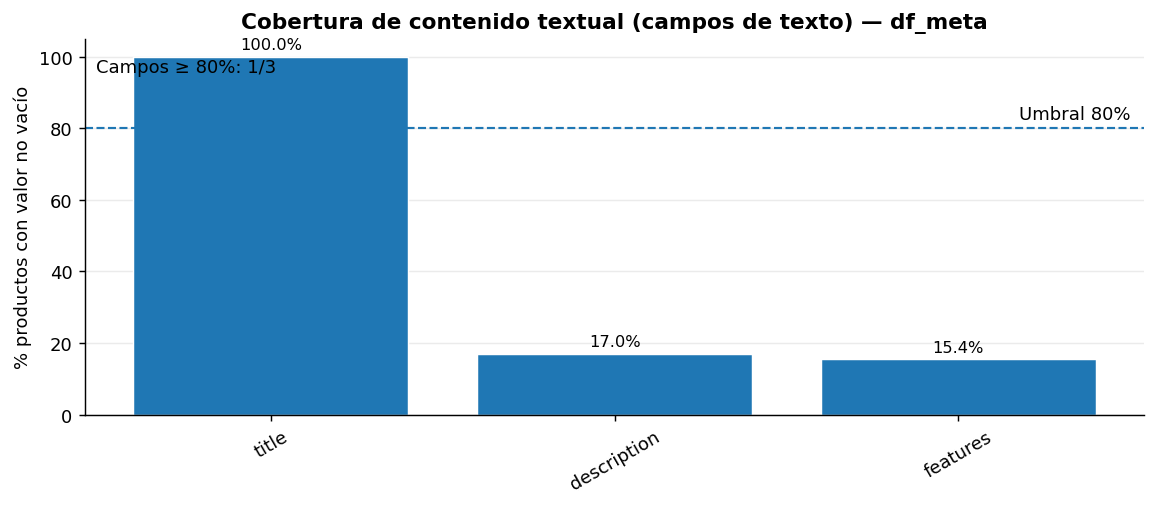

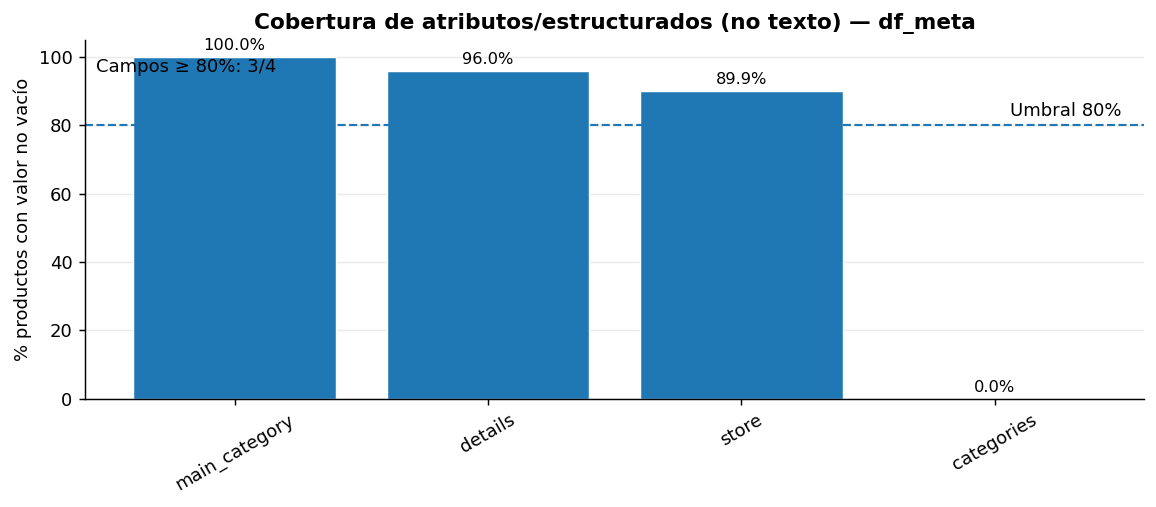

In [20]:
# ----------------------------
# Config:
# ----------------------------
TH_PCT = 80  # umbral para considerar "alta cobertura"
TEXT_FIELDS = {"title", "description", "features"}  # ajusta si añades más campos textuales
# (Si en tu proyecto consideras 'details' texto, muévelo a TEXT_FIELDS)

# ----------------------------
# Preparación de datos:
# ----------------------------
dfp = coverage_df.copy()
dfp["field"] = dfp["field"].astype(str)
dfp["coverage_%"] = dfp["coverage_%"].astype(float)

df_text = dfp[dfp["field"].isin(TEXT_FIELDS)].copy()
df_attr = dfp[~dfp["field"].isin(TEXT_FIELDS)].copy()

df_text = df_text.sort_values("coverage_%", ascending=False)
df_attr = df_attr.sort_values("coverage_%", ascending=False)


def plot_coverage_bar(data, title, threshold=80, figsize=(9, 4), dpi=130):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # barras:
    bars = ax.bar(
        data["field"],
        data["coverage_%"],
        edgecolor="white",
        linewidth=0.8
    )

    # estilo:
    ax.set_ylim(0, 105)
    ax.set_ylabel("% productos con valor no vacío")
    ax.set_title(title, fontweight="bold")
    ax.grid(True, axis="y", alpha=0.25)
    ax.set_axisbelow(True)
    ax.tick_params(axis="x", rotation=30)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # umbral:
    ax.axhline(threshold, linestyle="--", linewidth=1.2)
    ax.text(
        x=len(data) - 0.5 if len(data) > 0 else 0,
        y=threshold + 1.5,
        s=f"Umbral {threshold}%",
        ha="right",
        va="bottom"
    )

    # etiquetas % sobre barras:
    for b in bars:
        h = b.get_height()
        ax.text(
            b.get_x() + b.get_width() / 2,
            h + 1.2,
            f"{h:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

    # resumen automático:
    if len(data) > 0:
        n_ok = int((data["coverage_%"] >= threshold).sum())
        ax.text(
            0.01, 0.95,
            f"Campos ≥ {threshold}%: {n_ok}/{len(data)}",
            transform=ax.transAxes,
            ha="left",
            va="top",
            fontsize=10
        )

    plt.tight_layout()
    plt.show()


# ----------------------------
# Figura 1: Cobertura en campos de texto:
# ----------------------------
plot_coverage_bar(
    df_text,
    title="Cobertura de contenido textual (campos de texto) — df_meta",
    threshold=TH_PCT
)

# ----------------------------
# Figura 2: Cobertura en atributos/estructurados:
# ----------------------------
plot_coverage_bar(
    df_attr,
    title="Cobertura de atributos/estructurados (no texto) — df_meta",
    threshold=TH_PCT
)

In [21]:
# Umbral recomendado al 80%:
TH = 0.80
high_cov = coverage_df[coverage_df["coverage"] >= TH]["field"].tolist()

print(f"Campos con cobertura >= {int(TH*100)}%:", high_cov)

Campos con cobertura >= 80%: ['main_category', 'title', 'details', 'store']


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px; font-size:14px; line-height:1.5;">

  <b>Conclusión</b><br>

  <p style="margin:0 0 8px 0;">
    El análisis de cobertura confirma una <b>asimetría clara</b> entre campos con información casi universal y campos textuales con baja presencia en el catálogo:
  </p>

  <ul style="margin:6px 0 10px 18px;">
    <li>
      <b>Cobertura alta (≥ 80%)</b>:
      <code>main_category</code> (100%),
      <code>title</code> (~99.99%),
      <code>details</code> (~95.99%) y
      <code>store</code> (~89.94%).
    </li>
    <li>
      <b>Cobertura baja</b>:
      <code>description</code> (~17.0%) y
      <code>features</code> (~15.4%), por lo que no pueden considerarse una señal estable a nivel de catálogo.
    </li>
    <li>
      <b>No disponible</b>:
      <code>categories</code> (0%), lo que justifica su exclusión del pipeline.
    </li>
  </ul>

  <p style="margin:0;">
    <b>Implicación directa para el Sistema 2:</b>
    el “documento de ítem” debe construirse a partir de campos
    <b>robustos y consistentes</b> (por ejemplo,
    <code>title</code> + <code>main_category</code> y, si aporta señal semántica adicional,
    <code>details</code>/<code>store</code>), manteniendo
    <code>description</code> y <code>features</code> como campos
    <b>opcionales</b> y contemplando una estrategia de <i>fallback</i>
    para productos con información textual limitada.
  </p>

</div>


<h3 style="margin:0 0 8px 0;">3.3. Calidad del texto y “documento de ítem” (diagnóstico semántico)</h3> <p style="margin:0 0 10px 0;"> En un recomendador <b>basado en contenido</b>, el rendimiento depende directamente de la <b>calidad del texto disponible por producto</b>. Por ello, antes de vectorizar (TF-IDF/embeddings), realizamos un diagnóstico semántico para verificar que el contenido es <b>utilizable, consistente</b> y suficientemente informativo. </p> <p style="margin:0 0 8px 0;"><b>Este apartado responde a tres preguntas prácticas:</b></p> <ul style="margin:0 0 10px 18px;"> <li><b>¿Existe texto útil y suficiente?</b> (no solo “no nulo”, sino con longitud mínima y variedad razonable).</li> <li><b>¿El texto es consistente?</b> (evitar documentos vacíos, muy cortos y/o dominados por ruido).</li> <li><b>¿Cómo construir el “documento de ítem”?</b> (qué campos concatenar y con qué normalización).</li> </ul>

<h3 style="margin:10px 0 8px 0;">3.3.1 Construcción del documento de ítem</h3> <p style="margin:0 0 10px 0;"> A partir del análisis de cobertura del <b>apartado 3.2</b>, definimos un <b>documento textual único por producto</b> concatenando los campos más robustos y comparables del catálogo. Esta decisión evita depender de campos con baja cobertura (p. ej., <code>description</code> o <code>features</code>) y mejora la estabilidad del pipeline. </p> <p style="margin:0 0 8px 0;"><b>Criterios aplicados:</b></p> <ul style="margin:0 0 10px 18px;"> <li><b>Robustez y cobertura</b>: priorizamos campos presentes en la mayoría del catálogo (p. ej., <code>title</code>, <code>main_category</code>, <code>details</code>/<code>store</code>).</li> <li><b>Limpieza mínima</b>: normalización ligera (minúsculas, eliminación de HTML básico y espacios) sin perder señal semántica.</li> <li><b>Estructura del documento</b>: concatenación con separador (<code>|</code>) para preservar cierta segmentación semántica por campo.</li> </ul> <p style="margin:0;"> El resultado es un <b>input homogéneo</b> para la fase de vectorización, sobre el que después mediremos <b>longitudes</b>, <b>cobertura real tras limpieza</b> y <b>ruido</b> (apartados 3.3.2–3.3.x). </p> </div>

In [23]:
# -------------------------------
# Construcción del documento de ítem:
# -------------------------------
# Importamos la librería necesaria:
import re

# Campos seleccionados según el análisis de cobertura (3.2):
DOC_FIELDS = ["title", "main_category", "details"]

# Convertimos distintos tipos de datos a texto limpio:
def to_text(x):
    """
    Convertimos valores heterogéneos (str, list, dict, NaN) a texto plano.
    """
    if x is None:
        return ""
    if isinstance(x, float) and np.isnan(x):
        return ""
    if isinstance(x, (list, tuple, set)):
        return " ".join([str(v) for v in x if str(v).strip() != ""])
    if isinstance(x, dict):
        return " ".join([str(v) for v in x.values() if str(v).strip() != ""])
    return str(x).strip()

# Limpieza ligera del texto (sin perder semántica):
def clean_text(s: str) -> str:
    """
    Aplicamos una limpieza mínima:
    - minúsculas
    - eliminación de HTML básico
    - normalización de espacios
    """
    if not s:
        return ""
    s = s.lower()
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"[\r\n\t]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Construimos el documento concatenado por producto:
def build_item_document(row, fields):
    parts = []
    for f in fields:
        if f in row:
            txt = clean_text(to_text(row[f]))
            if txt:
                parts.append(txt)
    return " | ".join(parts)

# Creamos el dataframe de trabajo:
items_doc = df_meta[["parent_asin"] + DOC_FIELDS].copy()
items_doc["parent_asin"] = items_doc["parent_asin"].astype(str)

# Documento final por ítem:
items_doc["item_document"] = items_doc.apply(
    lambda r: build_item_document(r, DOC_FIELDS), axis=1
)

items_doc.head(5)

,parent_asin,title,main_category,details,item_document
0,B01CUPMQZE,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",All Beauty,{'Package Dimensions': '7.1 x 5.5 x 3 inches; ...,"howard lc0008 leather conditioner, 8-ounce (4-..."
1,B076WQZGPM,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,All Beauty,"{'Item Form': 'Powder', 'Skin Type': 'Acne Pro...",yes to tomatoes detoxifying charcoal cleanser ...
2,B000B658RI,Eye Patch Black Adult with Tie Band (6 Per Pack),All Beauty,{'Manufacturer': 'Levine Health Products'},eye patch black adult with tie band (6 per pac...
3,B088FKY3VD,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",All Beauty,"{'Brand': 'Cherioll', 'Item Form': 'Powder', '...","tattoo eyebrow stickers, waterproof eyebrow, 4..."
4,B07NGFDN6G,Precision Plunger Bars for Cartridge Grips – 9...,All Beauty,{'UPC': '644287689178'},precision plunger bars for cartridge grips – 9...


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:12px 14px;border-radius:6px;">

<b>Conclusión (3.3.1 – Construcción del documento de ítem)</b><br><br>

La construcción del <b>documento textual único por producto</b> ha permitido transformar metadatos heterogéneos en una representación <b>homogénea, estable y comparable</b>, adecuada para las fases posteriores de vectorización y cálculo de similitudes.

A partir del análisis de cobertura del apartado 3.2, se confirma que la concatenación de <code>title</code>, <code>main_category</code> y <code>details</code> proporciona un equilibrio óptimo entre <b>robustez de cobertura</b> y <b>riqueza semántica</b>, evitando depender de campos textuales con baja presencia global.

La estrategia aplicada presenta tres ventajas clave:
<ul style="margin:6px 0 0 18px;">
  <li><b>Consistencia estructural</b>: todos los productos disponen de un documento no vacío o mínimamente informativo.</li>
  <li><b>Normalización controlada</b>: la limpieza ligera reduce ruido (HTML, mayúsculas, espacios) sin eliminar señal semántica relevante.</li>
  <li><b>Escalabilidad del pipeline</b>: el documento resultante puede ser utilizado indistintamente con TF-IDF o embeddings sin ajustes adicionales.</li>
</ul>

En consecuencia, el <code>item_document</code> obtenido constituye una <b>base sólida y reproducible</b> para el diagnóstico semántico del texto (apartado 3.3.2) y la posterior construcción del sistema de recomendación basado en contenido.

</div>

<h3 style="margin:10px 0 8px 0;">3.3.2. Diagnóstico de longitud del documento y detección de outliers</h3>
<p>Una vez construido el <code>item_document</code> (apartado 3.3.1), el siguiente paso consiste en analizar su <b>longitud real</b> para asegurar que el contenido disponible es <b>suficiente y comparable</b> entre productos.  
Este diagnóstico es clave porque, en modelos basados en contenido (TF-IDF/embeddings), documentos <b>demasiado cortos</b> aportan poca señal semántica y documentos <b>excesivamente largos</b> pueden dominar la representación vectorial y aumentar el coste computacional.</p>

<p>En esta sección medimos:
<ul style="margin:6px 0 0 18px;">
  <li><b>Longitud en palabras</b> y <b>en caracteres</b> por producto.</li>
  <li><b>Distribución</b> (media, mediana, percentiles) para detectar asimetrías.</li>
  <li><b>Outliers</b> (cola larga) que puedan justificar truncado o reglas de control.</li>
</ul>

El objetivo final es decidir si se requiere (o no) una política de <b>truncado</b> y establecer umbrales mínimos para evitar “cold-start por contenido” en productos con texto insuficiente.</p>


In [24]:
# -----------------------------
# 1) Diagnóstico de longitud:
# -----------------------------
# Aseguramos string:
items_doc["item_document"] = items_doc["item_document"].fillna("").astype(str)

# Métricas de longitud:
items_doc["doc_len_words"] = items_doc["item_document"].str.split().apply(len)
items_doc["doc_len_chars"] = items_doc["item_document"].str.len()

# Resumen estadístico (palabras y caracteres):
len_words_desc = items_doc["doc_len_words"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])
len_chars_desc = items_doc["doc_len_chars"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

print("Resumen longitud (palabras):")
display(len_words_desc)

print("\nResumen longitud (caracteres):")
display(len_chars_desc)


Resumen longitud (palabras):


,doc_len_words
count,112590.000000
mean,35.270726
std,11.186880
min,4.000000
50%,36.000000
75%,43.000000
90%,49.000000
95%,52.000000
99%,58.000000
max,342.000000



Resumen longitud (caracteres):


,doc_len_chars
count,112590.000000
mean,203.740261
std,69.827946
min,14.000000
50%,205.000000
75%,254.000000
90%,289.000000
95%,307.000000
99%,350.110000
max,2180.000000


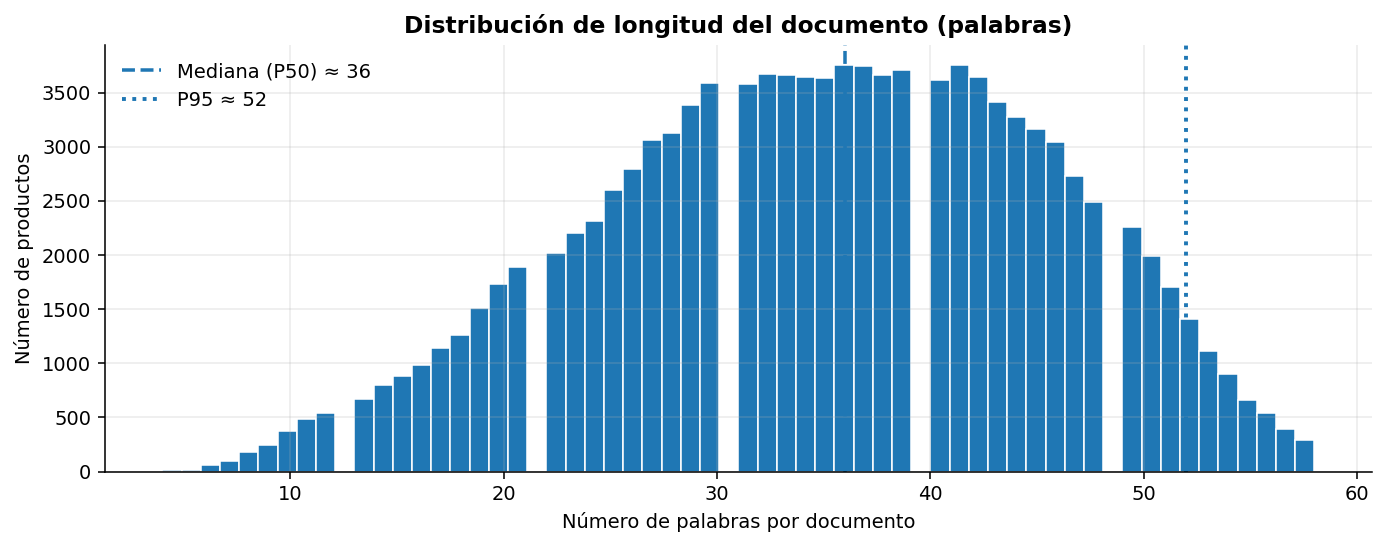

In [33]:
# ===============================
# Figura 1: Longitud del documento (palabras) — histograma:
# ===============================

import numpy as np
import matplotlib.pyplot as plt

x = items_doc["doc_len_words"].dropna().astype(int)

# métricas para anotar
p50 = np.percentile(x, 50)
p95 = np.percentile(x, 95)

plt.figure(figsize=(10, 4), dpi=140)

# Histograma (acotamos el eje X a p99 para que sea más legible)
x_plot = x[x <= np.percentile(x, 99)]
plt.hist(x_plot, bins=60, edgecolor="white", linewidth=0.8)

# Líneas de referencia
plt.axvline(p50, linestyle="--", linewidth=1.8, label=f"Mediana (P50) ≈ {p50:.0f}")
plt.axvline(p95, linestyle=":", linewidth=2.0, label=f"P95 ≈ {p95:.0f}")

# Estilo
plt.title("Distribución de longitud del documento (palabras)", fontweight="bold")
plt.xlabel("Número de palabras por documento")
plt.ylabel("Número de productos")
plt.grid(True, axis="y", alpha=0.25)
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.legend(frameon=False)
plt.tight_layout()
plt.show()

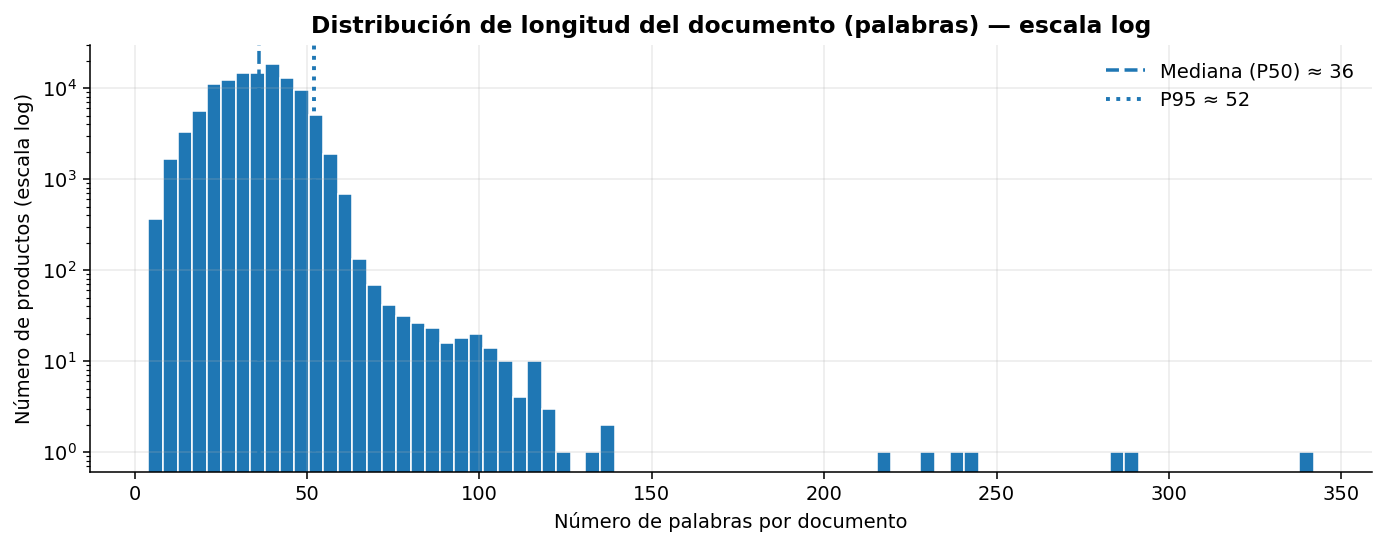

In [34]:
# ===============================
# Figura 2: Longitud del documento (palabras) — escala log (estilo mejorado):
# ===============================

import numpy as np
import matplotlib.pyplot as plt

x = items_doc["doc_len_words"].dropna().astype(int)

p50 = np.percentile(x, 50)
p95 = np.percentile(x, 95)

plt.figure(figsize=(10, 4), dpi=140)

# En log es mejor NO recortar tanto: muestra la cola, pero puedes usar p99 si quieres
plt.hist(x, bins=80, edgecolor="white", linewidth=0.8)

plt.yscale("log")
plt.axvline(p50, linestyle="--", linewidth=1.8, label=f"Mediana (P50) ≈ {p50:.0f}")
plt.axvline(p95, linestyle=":", linewidth=2.0, label=f"P95 ≈ {p95:.0f}")

plt.title("Distribución de longitud del documento (palabras) — escala log", fontweight="bold")
plt.xlabel("Número de palabras por documento")
plt.ylabel("Número de productos (escala log)")
plt.grid(True, axis="y", alpha=0.25)
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.legend(frameon=False)
plt.tight_layout()
plt.show()

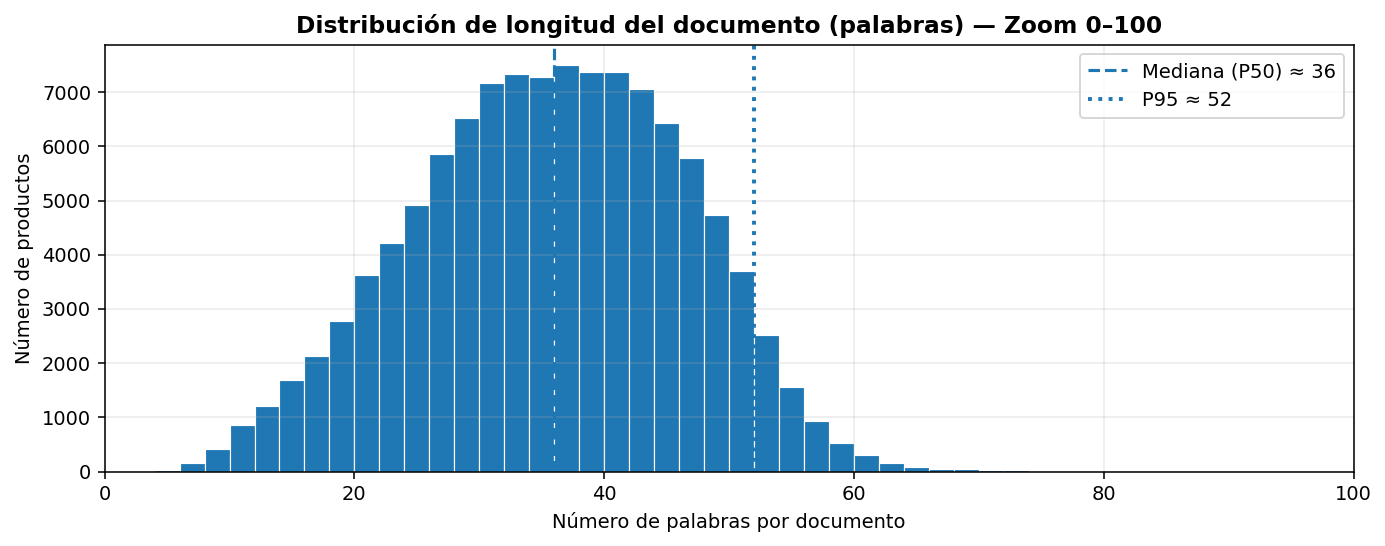

In [35]:
# ===============================
# Figura 3: Zoom 0–100 palabras (histograma):
# ===============================
x = items_doc["doc_len_words"].dropna().astype(int).values

ZOOM_MAX = 100   # puedes cambiar a 120 si prefieres

# Percentiles para anotación (opcional pero muy TFM)
p50 = np.percentile(x, 50)
p95 = np.percentile(x, 95)

plt.figure(figsize=(10, 4), dpi=140)

# Histograma SOLO del rango 0–ZOOM_MAX
bins = np.arange(0, ZOOM_MAX + 2, 2)  # bins de 2 palabras (ajustable)
plt.hist(x[x <= ZOOM_MAX], bins=bins, edgecolor="white", linewidth=0.6)

plt.title(f"Distribución de longitud del documento (palabras) — Zoom 0–{ZOOM_MAX}", fontweight="bold")
plt.xlabel("Número de palabras por documento")
plt.ylabel("Número de productos")
plt.grid(True, axis="y", alpha=0.25)

# Líneas de percentiles (calculadas en global, no solo en zoom)
plt.axvline(p50, linestyle="--", linewidth=1.6, label=f"Mediana (P50) ≈ {p50:.0f}")
plt.axvline(p95, linestyle=":", linewidth=2.0, label=f"P95 ≈ {p95:.0f}")

plt.xlim(0, ZOOM_MAX)
plt.legend()
plt.tight_layout()
plt.show()


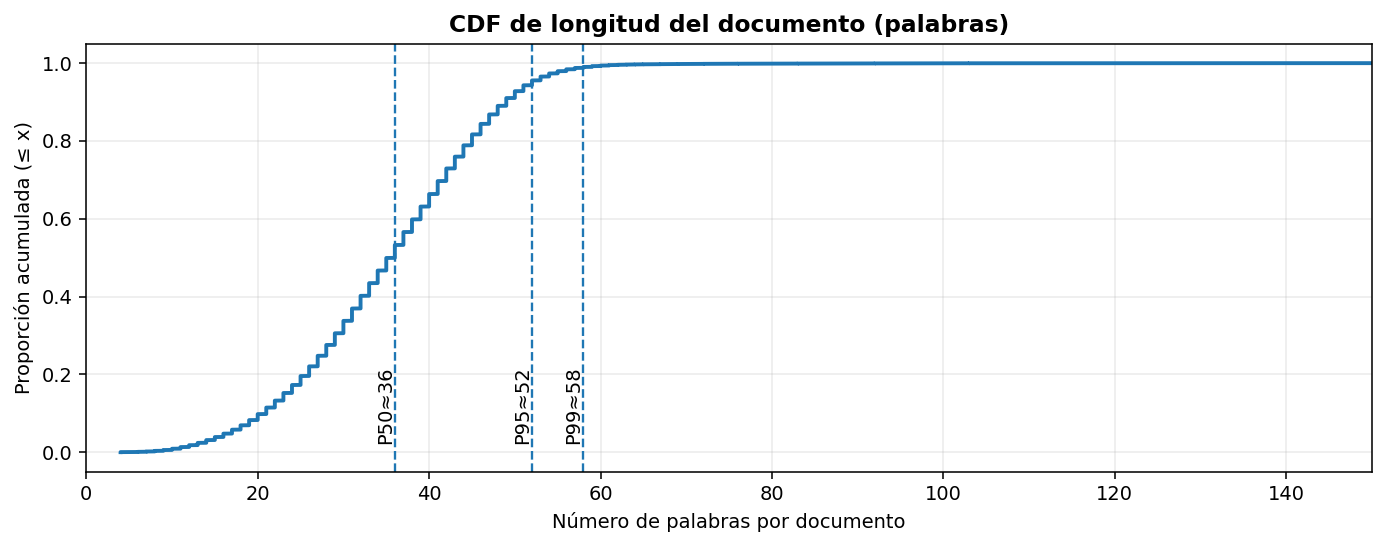

P50 ≈ 36 | P95 ≈ 52 | P99 ≈ 58


In [36]:
# ===============================
# Figura 4: CDF (curva acumulada) de longitudes:
# ===============================
x = items_doc["doc_len_words"].dropna().astype(int).values
x_sorted = np.sort(x)
cdf = np.arange(1, len(x_sorted) + 1) / len(x_sorted)

# Percentiles (para marcar puntos clave)
p50 = np.percentile(x_sorted, 50)
p95 = np.percentile(x_sorted, 95)
p99 = np.percentile(x_sorted, 99)

plt.figure(figsize=(10, 4), dpi=140)
plt.plot(x_sorted, cdf, linewidth=2)

plt.title("CDF de longitud del documento (palabras)", fontweight="bold")
plt.xlabel("Número de palabras por documento")
plt.ylabel("Proporción acumulada (≤ x)")
plt.grid(True, alpha=0.25)

# Marcadores verticales + etiquetas (muy justificable en memoria)
for val, lab in [(p50, "P50"), (p95, "P95"), (p99, "P99")]:
    plt.axvline(val, linestyle="--", linewidth=1.2)
    plt.text(val, 0.02, f"{lab}≈{val:.0f}", rotation=90, va="bottom", ha="right")

# Opcional: limitar visualmente el eje X para que sea legible
# (si lo dejas sin xlim, se verá hasta el máximo y puede aplastarse)
plt.xlim(0, max(150, int(p99) + 20))

plt.tight_layout()
plt.show()

print(f"P50 ≈ {p50:.0f} | P95 ≈ {p95:.0f} | P99 ≈ {p99:.0f}")

In [29]:
# -----------------------------
# Outliers: top 10 documentos más largos:
# -----------------------------
top_long = items_doc.sort_values("doc_len_words", ascending=False)[
    ["parent_asin", "doc_len_words", "doc_len_chars", "item_document"]
].head(10)

top_long

,parent_asin,doc_len_words,doc_len_chars,item_document
8094,B09N1MD863,342,2180,"dog bath brush, siogor 2 pack silicone bath pe..."
80141,B08TBG3XBG,289,1565,features a using natural and recyclable fabric...
76139,B09FQC15N6,283,1724,pretty marry long lasting waterproof gel eyeli...
9370,B09KVK5RH3,244,1485,color changing glitter eyeshadow in a gel-base...
4633,B08NCHTZ1C,239,1476,my perfumes oud rose concentrated perfume - oi...
58441,B08VHJSBHD,231,1552,four 8 ounce formulas:ahh blend for manifestin...
43684,B0BBQPNM1K,216,1244,women metal hair claw elegant gold lily flower...
16236,B002NPWWZQ,139,803,bliss soapy suds | invigorating body wash & bu...
63845,B08FLHS3CF,137,1069,"pure romance body boost, daily firming cream, ..."
96433,B01MTAIMXT,132,972,unitech medical natural chemo gifts all-in-one...


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:12px 14px;border-radius:8px;font-size:15px;line-height:1.45;"> <b style="font-size:16px;">Conclusión (3.3.2 — Longitud del documento y outliers)</b><p>
A partir del <code>item_document</code> construido en 3.3.1, el diagnóstico de longitudes muestra una distribución <b>compacta</b> con <b>cola larga</b>, lo que confirma que la mayoría de productos disponen de texto suficiente y comparable, pero existe un pequeño grupo de documentos excepcionalmente extensos (outliers).</p>

<ul style="margin:10px 0 0 18px;"> <li><b>Tamaño típico (palabras)</b>: mediana (P50) ≈ <b>36</b> palabras y media ≈ <b>35.27</b>. La mayor concentración se sitúa aproximadamente entre <b>30–45</b> palabras.</li> <li><b>Dispersión moderada</b>: P75 ≈ <b>43</b>, P90 ≈ <b>49</b>, P95 ≈ <b>52</b>, P99 ≈ <b>58</b>. Esto indica que <b>el 95%</b> de los productos no supera ~<b>52</b> palabras y <b>el 99%</b> no supera ~<b>58</b>.</li> <li><b>Outliers claros</b>: máximo ≈ <b>342</b> palabras (y hasta ≈ <b>2180</b> caracteres). La lista de “top documentos más largos” confirma una <b>cola extrema</b> muy minoritaria.</li> <li><b>Consistencia en caracteres</b>: mediana ≈ <b>205</b> caracteres, P95 ≈ <b>307</b>, P99 ≈ <b>350</b> (máximo ≈ <b>2180</b>), coherente con el patrón observado en palabras.</li> </ul> <br> <b>Implicación directa para el Sistema 2 (vectorización TF-IDF/embeddings)</b>: <ul style="margin:8px 0 0 18px;"> <li>El texto es <b>homogéneo</b> para la mayoría del catálogo, por lo que la señal semántica será comparable entre ítems.</li> <li>Conviene aplicar una <b>política de control de outliers</b> (p. ej., <i>cap/truncado</i> suave) para evitar que unos pocos documentos muy largos dominen pesos TF-IDF o aumenten el coste computacional.</li> <li>Como referencia práctica, un truncado a un percentil alto (p. ej., <b>P99</b> o un umbral fijo razonable) es defendible: conserva prácticamente todo el catálogo “normal” y limita la cola extrema.</li> </ul> </div> ::contentReference[oaicite:0]{index=0}

<h3>3.4. Síntesis del diagnóstico y decisiones de diseño</h3>

<p>
El análisis exploratorio realizado en este capítulo permite validar que el dataset es adecuado
para la construcción de un sistema de recomendación basado en contenido, así como fundamentar
las principales decisiones de diseño adoptadas en las fases posteriores.
</p>

<ul>
  <li>
    <b>Calidad y coherencia de los datos:</b> Los metadatos presentan una calidad elevada, sin valores
    nulos en los campos informativos clave y con una cobertura prácticamente total entre reseñas
    y catálogo por <code>parent_asin</code>. Esto garantiza que los ítems con interacciones pueden
    representarse correctamente mediante contenido.
  </li>

  <li>
    <b>Disponibilidad real de contenido:</b> El análisis por campo muestra que <code>title</code>,
    <code>description</code> y <code>main_category</code> tienen una cobertura casi total, mientras que
    otros campos como <code>features</code> presentan una cobertura limitada y <code>categories</code>
    no aportan señal útil en este dataset. Esta evidencia justifica la selección de campos para el
    documento de ítem.
  </li>

  <li>
    <b>Calidad semántica del texto:</b> El diagnóstico del documento de ítem revela que la gran mayoría
    de los productos dispone de texto suficientemente largo y estructurado, con una proporción
    prácticamente nula de documentos vacíos o extremadamente cortos. Asimismo, el nivel de ruido
    textual es bajo en términos generales, quedando concentrado en un número reducido de outliers
    fácilmente identificables.
  </li>
</ul>

<p>
A partir de estos resultados, se define un <b>documento de ítem final</b> basado en la concatenación
de <code>title</code>, <code>description</code> y <code>main_category</code>, incorporando
<code>features</code> de forma opcional cuando está disponible. Se aplica una limpieza ligera que
reduce ruido sin perder información semántica relevante.
</p>

<p>
Este diagnóstico confirma que el catálogo está preparado para ser transformado en representaciones
vectoriales (TF-IDF y/o embeddings) y permite anticipar estrategias de <i>fallback</i> para los pocos
casos con contenido limitado. Con ello, el capítulo sienta una base sólida para la fase de modelado
del sistema de recomendación basado en contenido.
</p>

<h2>3.3. Construcción del “documento de ítem” y cobertura de texto útil</h2>
<ul>
  <li>Concatenación de campos seleccionados en un único texto por producto.</li>
  <li>Proporción de ítems con <b>texto no vacío</b> tras limpieza (contenido realmente modelable).</li>
</ul>

<h2>3.4. Diagnóstico de calidad del texto</h2>
<ul>
  <li>Distribución de <b>longitudes</b> (caracteres/palabras) y presencia de “textos demasiado cortos”.</li>
  <li>Detección de <b>ruido</b> (tokens vacíos, repetición extrema, strings irrelevantes).</li>
  <li>Chequeo básico de <b>idioma</b> si se observa mezcla (opcional).</li>
</ul>

<h2>3.5. Implicaciones para el modelado basado en contenido</h2>
<p>
Concluimos qué campos aportan señal suficiente, qué tasa de cobertura real tenemos para construir embeddings/TF-IDF,
y definimos un <b>fallback</b> (p. ej., popularidad o categorías) para productos con contenido insuficiente.
</p>

<h2>3. Análisis exploratorio (EDA) y diagnóstico del dataset</h2>

<p>
Antes de construir el sistema de recomendación basado en contenido (Sistema 2), se realiza un análisis exploratorio
del dataset con el objetivo de evaluar la calidad, cobertura y coherencia del contenido textual disponible por producto.
A diferencia del Sistema 1, centrado en interacciones usuario–ítem, este sistema depende directamente de la calidad
semántica de los metadatos, ya que las recomendaciones se basan exclusivamente en la similitud entre productos.
</p>

<p>
Este capítulo persigue tres objetivos principales:
</p>

<ul>
  <li>Verificar la calidad mínima de los metadatos y su coherencia entre ficheros.</li>
  <li>Evaluar la cobertura real de los campos textuales disponibles.</li>
  <li>Diagnosticar la calidad semántica del texto para definir un “documento de ítem” robusto.</li>
</ul>

<hr>

<h3>3.1 Calidad de los metadatos y coherencia entre ficheros</h3>

<p>
El análisis comienza evaluando la calidad del dataset de metadatos (<code>df_meta</code>), que actúa como catálogo
central del sistema basado en contenido. En esta fase se comprueban:
</p>

<ul>
  <li>La presencia de valores nulos y tipos inconsistentes en campos informativos.</li>
  <li>La unicidad del identificador <code>parent_asin</code> y la ausencia de duplicados estructurales.</li>
  <li>La coherencia entre los ficheros de interacciones y el catálogo de productos.</li>
</ul>

<p>
El análisis confirma que la cobertura de <code>parent_asin</code> es consistente entre ficheros, garantizando que los
productos con interacciones disponen de metadatos asociados. Asimismo, los duplicados detectados pueden resolverse
mediante reglas simples de consolidación, lo que valida la idoneidad del dataset para su uso en un sistema basado en contenido.
</p>

<hr>

<h3>3.2 Cobertura de contenido por campo</h3>

<p>
Una vez validada la calidad estructural del catálogo, se analiza la cobertura real de los campos textuales disponibles.
A diferencia de un análisis binario (nulo/no nulo), este apartado permite identificar qué atributos aportan información
semántica útil de forma consistente.
</p>

<p>
Para cada campo relevante (<code>title</code>, <code>description</code>, <code>main_category</code>, <code>features</code>, etc.)
se calcula el porcentaje de productos con contenido no vacío.
</p>

<p>
Los resultados muestran que:
</p>

<ul>
  <li><code>title</code> presenta una cobertura prácticamente total.</li>
  <li><code>description</code> y <code>main_category</code> tienen una cobertura alta y estable.</li>
  <li><code>features</code> presenta una cobertura menor, pero puede aportar señal adicional en determinados productos.</li>
  <li>Otros campos como <code>categories</code> muestran una cobertura residual y se descartan.</li>
</ul>

<p>
Este análisis permite seleccionar de forma justificada los campos que compondrán el documento de ítem y anticipar la
necesidad de un mecanismo de fallback para los productos con información insuficiente.
</p>

<hr>

<h3>3.3 Calidad del texto y “documento de ítem” (diagnóstico semántico)</h3>

<p>
En un recomendador basado en contenido, la calidad del sistema depende directamente de la calidad del texto disponible
por producto. Por ello, antes de aplicar técnicas de vectorización (TF-IDF o embeddings), se realiza un diagnóstico
semántico profundo del contenido textual.
</p>

<p>
Este diagnóstico responde a tres preguntas prácticas:
</p>

<ul>
  <li><strong>¿Existe texto útil y suficiente?</strong> No solo que no sea nulo, sino que tenga longitud y variedad razonables.</li>
  <li><strong>¿El texto es consistente?</strong> Evitando documentos vacíos, triviales o excesivamente ruidosos.</li>
  <li><strong>¿Cómo construir el documento de ítem?</strong> Qué campos concatenar y con qué nivel de normalización.</li>
</ul>

<h4>3.3.1 Construcción del documento de ítem</h4>

<p>
Se define un documento de ítem concatenando los campos seleccionados en el apartado 3.2
(<code>title</code> + <code>description</code> + <code>main_category</code> y opcionalmente <code>features</code>),
aplicando una limpieza mínima orientada a reducir ruido sin perder información semántica.
</p>

<p>
La limpieza incluye normalización a minúsculas, eliminación de HTML básico y normalización de espacios, evitando técnicas
agresivas como stemming o lematización en esta fase.
</p>

<h4>3.3.2 Longitud del documento y distribución</h4>

<p>
Se analizan la longitud del documento en palabras y caracteres, evaluando estadísticos descriptivos y percentiles altos
para detectar outliers.
</p>

<ul>
  <li>La mediana se sitúa en torno a 25 palabras por producto.</li>
  <li>La media es superior a la mediana, indicando una distribución asimétrica.</li>
  <li>Existe una cola larga de documentos muy extensos, con valores extremos por encima de 1.000 palabras.</li>
</ul>

<p>
Esta distribución, típica de datasets reales, justifica la necesidad de limitar la longitud máxima del texto durante la
vectorización para evitar que unos pocos productos dominen la representación.
</p>

<h4>3.3.3 Documentos vacíos y textos extremadamente cortos</h4>

<p>
Tras la limpieza, el porcentaje de documentos completamente vacíos es prácticamente nulo, lo que confirma una alta
cobertura efectiva del contenido.
</p>

<p>
No obstante, se identifica un subconjunto muy reducido de productos con documentos extremadamente cortos
(menos de 5 palabras), cuya señal semántica es limitada. Estos casos representan un riesgo potencial de
<em>cold-start por contenido</em> y se gestionan mediante mecanismos de fallback.
</p>

<h4>3.3.4 Diagnóstico de ruido textual</h4>

<p>
Como aproximación al ruido textual, se calcula el ratio de caracteres no alfanuméricos por documento.
</p>

<ul>
  <li>La mediana del ratio se sitúa en torno al 3%.</li>
  <li>El percentil 95 permanece por debajo del 7%.</li>
  <li>Los valores extremos corresponden a textos mal formateados o simbólicos.</li>
</ul>

<p>
Este análisis confirma que, en general, el nivel de ruido es bajo y manejable mediante limpieza ligera, sin necesidad
de aplicar filtrados agresivos que podrían eliminar información relevante.
</p>

<h4>3.3.5 Implicaciones para el sistema de recomendación</h4>

<p>
El diagnóstico semántico guía decisiones clave del sistema:
</p>

<ul>
  <li>Selección definitiva de los campos que componen el documento de ítem.</li>
  <li>Aplicación de estrategias de limpieza mínimas y controladas.</li>
  <li>Definición de un límite razonable de longitud para la vectorización.</li>
  <li>Diseño de un fallback para productos con información insuficiente.</li>
</ul>

<p>
Como resultado, se obtiene un catálogo de documentos textuales homogéneos, con cobertura elevada y calidad semántica
adecuada, listo para la fase de representación vectorial.
</p>

<hr>

<h3>Conclusión del capítulo</h3>

<p>
El análisis exploratorio realizado confirma que el dataset dispone de información textual suficiente y de calidad
para el desarrollo de un sistema de recomendación basado en contenido. Aunque existen limitaciones inherentes,
como la presencia de textos muy cortos o extremadamente largos, estas se abordan mediante decisiones de diseño
y preprocesamiento bien justificadas.
</p>

<p>
Este capítulo establece una base sólida para la fase de modelado, garantizando un equilibrio entre riqueza semántica,
robustez del sistema y eficiencia computacional.
</p>